# Bearing capacity of piles group with Python

Usually, in common engineering practice, there is the abit to desing the lenght of piles in group taking into considerations the most loaded pile. In most of the cases there is a back and forth between the geotech and structural engineer where first the firs give to the second piles springs and bearing capacity, and the second extract the highest load on pile as the dimensioning one.
Recently Marco stepped  into this <a href = "https://www.researchgate.net/publication/324128051_Bearing_capacity_of_pile_groups_under_vertical_eccentric_load"> article  </a> from Laora, de Sanctis and Aversa from  "Acta Geotecnica".
We found the contribution valuable and we though it could be interesting for professionals to develop a tools able to implement this formulation.
Reference shall be made to article for a detailed explanation of the therethical background involved, the underlying principle is that when in group the bearing capacity of piles is increased by the axial contribution in traction of piles on the opposite side of load directions.


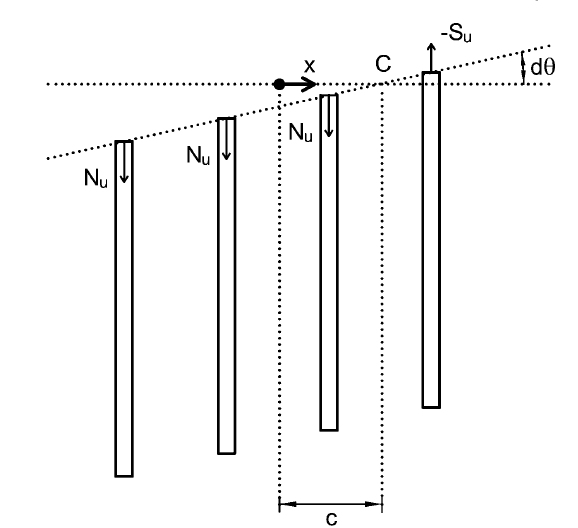

The final objective is to to create an interaction diagram able to provide a distance from failure for each load combinations.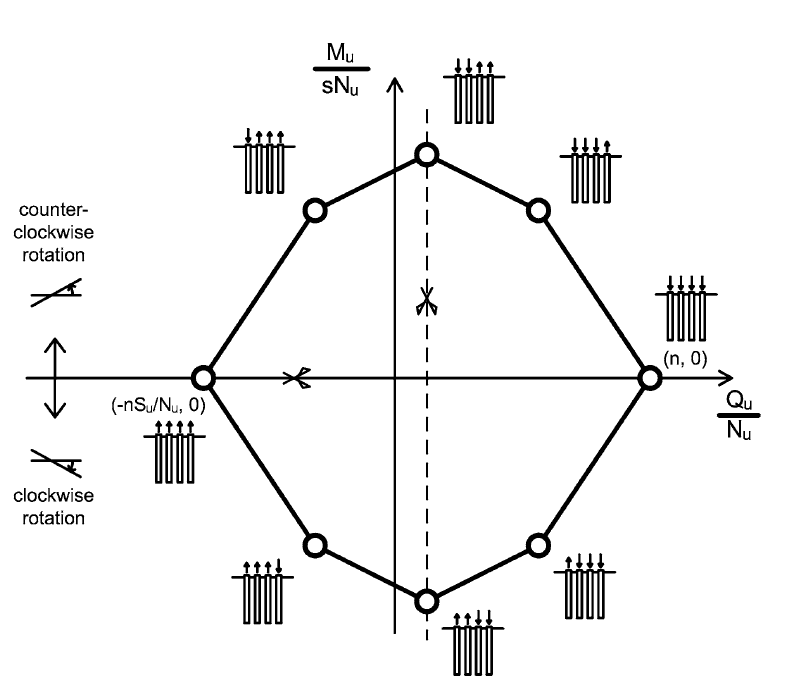

Each node of the domain reppresent a different load configuration where, according to the direction of the moment and the normal action acting of the raft, the piles are loaded in a different way. Just to give some one easy example: if one look at the right side of the diagram, when no moment is acting on the foundation, of course the ultimate bearing capacity of the group is n times the bearing capacity of a single pile (n is the number of piles). The same in traction (left side of the diagram). To compute the bearing capacity for each "node" of the diagram the following formula is used:

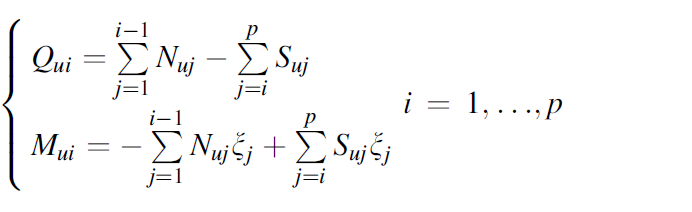

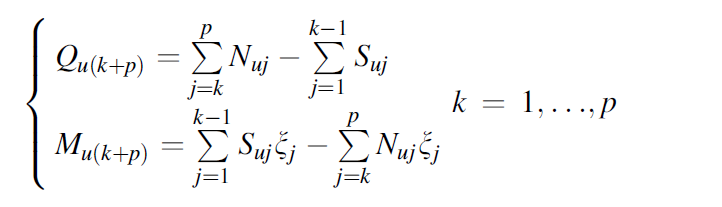

The first formula refer to the right side of the plot (moment major than 0 or clockwise rotation) and the second to the left side of the diagram (moment minor than 0 or anti-clockwise rotation). ξ value is defined as follow:

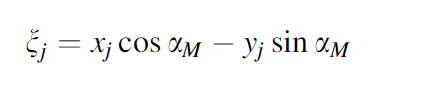

α is the angle between the moment in x an y directions acting on the raft foundation

After some introduction, let's dive into the code and start importing the packages we are goin to use for our purpose.

In [13]:
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

First of all we create 2 csv containing respectively the piles positions with the bearing capacity (compression and tension) and one with the global loads acting on the foundation. The csv are imported in the code as data frames. 

In [14]:
df_piles = pd.read_csv('piles_group.csv', delimiter=',')
display(df_piles)
df_loads = pd.read_csv('piles_loads_check.csv', delimiter=',')
display(df_loads)

,Pile [n],X [m],Y [m],Rcd [kN],Rtd [kN]
0,1,-5.4,-1.8,2683,1619
1,2,-1.8,-1.8,2683,1619
2,3,1.8,-1.8,2683,1619
3,4,5.4,-1.8,2683,1619
4,5,-5.4,1.8,2683,1619
5,6,-1.8,1.8,2683,1619
6,7,1.8,1.8,2683,1619
7,8,5.4,1.8,2683,1619


,Ned [kN],Medx [kNm],Medy [kNm]
0,10518.9,4000,5255.292509
1,10477.4,3000,-5464.112211
2,14026.8,-2000,-6256.926837
3,12454.3,-1000,6492.236397
4,12091.4,-500,6585.446026
5,13985.3,-1500,-6013.648178
6,12412.8,2500,5671.328276
7,12049.9,-3500,5158.151050
8,10266.6,2000,4249.476622
9,10238.1,100,4441.974517


Let's calculate the resulting moment and the angle α for each load combination.

In [15]:
def calc_alfa_M(df): #REQUIRES DF LOADS
    mtot = []
    alpha = []
    for mx,my in zip(df['Medx [kNm]'],df['Medy [kNm]']):
        m = np.sqrt(mx**2+my**2)
        
        if mx>0:
            a = np.degrees(np.arccos(my/m))
            mtot.append(m)
        else:
            a = 360 - np.degrees(np.arccos(my/m))
            mtot.append(-m)
        alpha.append(a)
        
    df['alpha [°]'] = alpha
    df['Medtot [kNm]'] = mtot
    
    return df

df_loads = calc_alfa_M(df_loads)
display(df_loads)

,Ned [kN],Medx [kNm],Medy [kNm],alpha [°],Medtot [kNm]
0,10518.9,4000,5255.292509,37.276122,6604.4
1,10477.4,3000,-5464.112211,151.231583,6233.5
2,14026.8,-2000,-6256.926837,197.726257,-6568.8
3,12454.3,-1000,6492.236397,351.243541,-6568.8
4,12091.4,-500,6585.446026,355.658148,-6604.4
5,13985.3,-1500,-6013.648178,194.005643,-6197.9
6,12412.8,2500,5671.328276,23.788549,6197.9
7,12049.9,-3500,5158.151050,325.841628,-6233.5
8,10266.6,2000,4249.476622,25.203842,4696.6
9,10238.1,100,4441.974517,1.289654,4443.1


The strategy is to build a number of domains based on the different load directions. The domain will be then build fixing α and then plotting the loads values. First of all let's define how to compute ξ value.

In [16]:
def calc_xi (a,df): #REQUIRES DF PILES
    xi = []
    for x,y in zip(df['X [m]'],df['Y [m]']):
        xi_j = x * np.cos(np.radians(a)) - y * np.sin(np.radians(a))
        xi.append(xi_j)
    df['xi [-]'] = xi
    return df

Now let's apply the previous formula for the domain calculation. Note the p and k indexes are for computing the upper and lower side respectively of the domain.

In [17]:
def calc_domain(a,df): #REQUIRES DF PILES

    Nu = []
    Mu = []
    
    df['xi_c'] = [i*j for i,j in zip(df['Rcd [kN]'],df['xi [-]'])]
    df['xi_t'] = [i*j for i,j in zip(df['Rtd [kN]'],df['xi [-]'])]
    
    df_sort = df.sort_values(['xi [-]'], ascending = True)
    
    rcd_somm = df_sort['Rcd [kN]']
    rtd_somm = df_sort['Rtd [kN]']
    rcd_psi_somm = df_sort['xi_c']
    rtd_psi_somm = df_sort['xi_t']
    
    #UPPER SIDE DOMAIN
    for i in range(len(rcd_somm)):
    
        Nu.append(sum(rcd_somm[: i]) - sum(rtd_somm[i :]))
        Mu.append(sum(- rcd_psi_somm[: i]) + sum(rtd_psi_somm[i:]))
    
    #LOWER SIDE DOMAIN
    for i in range(len(rcd_somm)):    
 
        Nu.append(sum(rcd_somm[i:]) - sum(rtd_somm[:i]))
        Mu.append(sum(rcd_psi_somm[: i]) - sum(rtd_psi_somm[i:]))
    
    #LAST POINT TO CLOSE THE DOMAIN
    Nu.append(Nu[0])
    Mu.append(Mu[0])
    Nu = np.array(Nu)
    Mu = np.array(Mu)
    
    return Mu,Nu

Let's now iterate over the different α values and plot the domain:

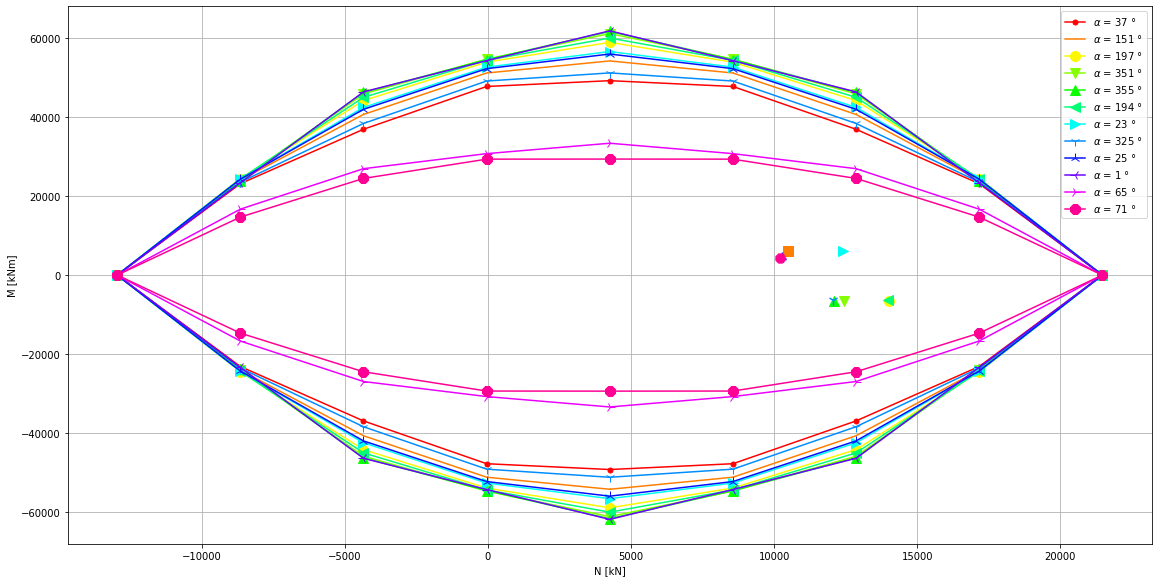

In [18]:
# ALL AVAILABLE MARKERS OF MATPLOTLIB
markers = [k for k in Line2D.markers.keys()]

# COLOR FUNCTION 
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

alpha_calc = df_loads['alpha [°]'].unique()
cmap = get_cmap(len(alpha_calc) + 1)

fig, ax = plt.subplots(figsize=(16,8))

# ITERATION OVER DIFFERENT VALUES OF ALPHA
for n,alpha in enumerate(alpha_calc):
    
    #CALULATE XI
    df_piles = calc_xi(alpha,df_piles)
    
    #CALCULATE DOMAIN
    Mu,Nu = calc_domain(alpha,df_piles)
    
    #PLOT
    ax.plot(Nu, Mu, label='$α$ = ' + str(int(alpha)) + ' °', marker=markers[n], color=cmap(n), markersize=10)
    loads_plot = df_loads[df_loads['alpha [°]'] == alpha]
    ax.scatter(loads_plot['Ned [kN]'], loads_plot['Medtot [kNm]'], color=cmap(n), marker=markers[n], s=100)

ax.legend()
plt.grid()
fig.tight_layout()
ax.set_xlabel('N [kN]')
ax.set_ylabel('M [kNm]')
plt.show()

For each load combination we can then compute the utilization ratio. The ratio is meant as the distance of the point from the domain considering constant eccentricity, the slope of the segment connecting the origin to the load combination. For this scope we are going to use the following package.

In [19]:
import shapely
from shapely.geometry import LineString, Point

We will then define a function where we iterate over all the segment componing the domain, find the minimum distance between the load combiantion and the domain and then compute the utilization ration.

In [20]:
def calc_FS(M,N,Mu,Nu):
    
    # INITIALIZE THE FIRST POINT OF THE SEGMENT
    x0,y0 = Nu[0],Mu[0]
   
    # FORCE LINE (COSTANT ECCENTRICITY)
    A = (min(Nu), min(Nu)*M/N)
    B = (max(Nu), max(Nu)*M/N)
    
    # DUMMY DISTANCE
    dist = (max(Nu)-min(Nu))*10
    
    #DISTANCE OF THE LOAD COMBINATION FROM THE ORIGIN
    dist_force = np.sqrt((M)**2+(N)**2)
    
    #ITERATE OVER ALL THE SEGMENTS COMPONING THE DOMAIN
    for i in range(1,len(Mu)):
             
        # SEGMENT LINE 
        C = (x0, y0)
        D = (Nu[i], Mu[i])
        
        line1 = LineString([A, B])
        line2 = LineString([C, D])
        
        # POINT OF INTERSECTION
        int_pt = line1.intersection(line2)
        
        #CHECK IF THE TWO LINES INTERSECT
        if str(int_pt) != 'LINESTRING EMPTY':

            dist_t = np.sqrt((int_pt.x-N)**2+(int_pt.y-M)**2)
            
            # UPDATE THE MINIMUM DISTANCE
            if dist_t<dist:
    
                dist = dist_t
                x = int_pt.x
                y = int_pt.y
        
                dist_tot = np.sqrt((x)**2+(y)**2)
                UR = dist_force/dist_tot
                
        x0,y0 = Nu[i],Mu[i]
                
    return UR,x,y,dist


Let's now iterate and use the function over all the load combinations.

In [21]:
ur = []

for i in df_loads.index:
    Mu,Nu = calc_domain(df_loads.loc[i,'alpha [°]'],df_piles)
    UR,x,y,dist = calc_FS(df_loads.loc[i,'Medtot [kNm]'],df_loads.loc[i,'Ned [kN]'],Mu,Nu)
    ur.append(float(UR))

df_loads['UR [-]'] = ur
display(round(df_loads,1))

,Ned [kN],Medx [kNm],Medy [kNm],alpha [°],Medtot [kNm],UR [-]
0,10518.9,4000,5255.3,37.3,6604.4,0.6
1,10477.4,3000,-5464.1,151.2,6233.5,0.6
2,14026.8,-2000,-6256.9,197.7,-6568.8,0.7
3,12454.3,-1000,6492.2,351.2,-6568.8,0.7
4,12091.4,-500,6585.4,355.7,-6604.4,0.7
5,13985.3,-1500,-6013.6,194.0,-6197.9,0.7
6,12412.8,2500,5671.3,23.8,6197.9,0.7
7,12049.9,-3500,5158.2,325.8,-6233.5,0.6
8,10266.6,2000,4249.5,25.2,4696.6,0.5
9,10238.1,100,4442.0,1.3,4443.1,0.5


Concluding, we developed using Python a promising method to compute the bearing capacity of a group of piles. The method looks like very promising and able to generate substantial savings in foundation desing.